<a href="https://colab.research.google.com/github/pratik-poudel/datacrunch/blob/main/24th%20April%20Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import gc
# pd.options.display.float_format| = "{:.2f}".format
pd.options.display.max_columns = 500


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
import requests
from scipy import stats

import lightgbm as lgb

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import sklearn
from sklearn import *
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.utils.testing import all_estimators
from sklearn.base import RegressorMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import make_scorer
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.multioutput import RegressorChain


import requests
import time
from scipy import stats

import lightgbm as lgb
import xgboost as xgb


In [2]:
train_datalink_X = 'https://tournament.datacrunch.com/data/X_train.csv'  
train_datalink_y = 'https://tournament.datacrunch.com/data/y_train.csv'
hackathon_data_link = 'https://tournament.datacrunch.com/data/X_test.csv'

In [3]:
train = pd.read_csv(train_datalink_X)
target = pd.read_csv(train_datalink_y)
test = pd.read_csv(hackathon_data_link)

In [8]:

feat= [f for f in train.columns if "Feature" in f]
print(feat)

['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10', 'Feature_11', 'Feature_12', 'Feature_13', 'Feature_14']


In [ ]:
def scorer(y_test, y_pred):
    # print(y_test)
    true_r, pred_r = y_test['target_r'], y_pred[:, 0]
    true_g, pred_g = y_test['target_g'], y_pred[:, 1]
    true_b, pred_b = y_test['target_b'], y_pred[:, 2]

    score_r = (stats.spearmanr(true_r, pred_r))[0]
    score_g = (stats.spearmanr(true_r, pred_r))[0]
    score_b = (stats.spearmanr(true_r, pred_r))[0]
    # print(score_r, score_g, score_b)

    # print(score)
    # print('Score as calculated for the leader board (っಠ‿ಠ)っ {}'.format((score_r + score_g + score_b)/3))
    return (score_r + score_g + score_b)/ 3 


n_split=3
n_repeat=2

my_scorer = make_scorer(scorer, greater_is_better=True)
cv = RepeatedKFold(n_splits=n_split, n_repeats=n_repeat, random_state=60)
regressors = [
                # ('AdaBoostRegressor', sklearn.ensemble.AdaBoostRegressor()),
                # ('BaggingRegressor', sklearn.ensemble.BaggingRegressor()),
                # ('BayesianRidge', sklearn.linear_model.BayesianRidge()),
                ('DecisionTreeRegressor', sklearn.tree.DecisionTreeRegressor()),
                # ('ElasticNet', sklearn.linear_model.ElasticNet()),
                # ('ExtraTreeRegressor', sklearn.tree.ExtraTreeRegressor()),
                # ('ExtraTreesRegressor', sklearn.ensemble.ExtraTreesRegressor()),
                # ('GradientBoostingRegressor', sklearn.ensemble.GradientBoostingRegressor()),
                # ('HistGradientBoostingRegressor',sklearn.ensemble.HistGradientBoostingRegressor()),
                # ('HuberRegressor', sklearn.linear_model.HuberRegressor()),
                # ('Lars', sklearn.linear_model.Lars()),
                # ('Lasso', sklearn.linear_model.Lasso()),
                # ('LassoLars', sklearn.linear_model.LassoLars()),
                # ('LassoLarsIC', sklearn.linear_model.LassoLarsIC()),
                # ('LinearRegression', sklearn.linear_model.LinearRegression()),
                # ('OrthogonalMatchingPursuit',sklearn.linear_model.OrthogonalMatchingPursuit()),
                # ('PassiveAggressiveRegressor',sklearn.linear_model.PassiveAggressiveRegressor()),
                # ('RANSACRegressor', sklearn.linear_model.RANSACRegressor()),
                # ('RandomForestRegressor', sklearn.ensemble.RandomForestRegressor()),
                # ('Ridge', sklearn.linear_model.Ridge()),
                # ('SGDRegressor', sklearn.linear_model.SGDRegressor()),
                # ('TransformedTargetRegressor',sklearn.compose.TransformedTargetRegressor()),
                # ("XGBRegressor", xgb.XGBRegressor(objective='reg:squarederror')),
                # ("LGBMRegressor", lgb.LGBMRegressor())
                ]

results, names = list(), list()
mean_scores = []
std_scores = []
time_taken_seconds = []
for name, model in regressors:
    if 'random_state' in model.get_params().keys():
        model.set_params(random_state=60)
    if 'n_jobs' in model.get_params().keys():
            model.set_params(n_jobs=-1)

    start = time.time()
    wrapper = RegressorChain(model)
    scores = cross_val_score(wrapper, train[feat], target, scoring=my_scorer, 
                            #  n_jobs=-1, 
                             cv= cv)
    results.append(scores)
    names.append(name)
    mean_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))
    end = time.time()
    time_taken= end-start
    time_taken_seconds.append(np.round(time_taken, 2))
    print('>%s %.3f (%.3f), (%.3f)' % (name, np.mean(scores), np.std(scores), time_taken), "seconds")

df1 = pd.DataFrame(np.column_stack([names, mean_scores, std_scores, time_taken_seconds]), 
                columns=['models', 'mean_score', 'std_score', 'time_taken_seconds'])
df2 = pd.DataFrame(results, columns=["".join('score'+ str(i)) for i in range(n_split*n_repeat) ])
final_df = pd.concat([df1, df2], axis=1)
int_cols = [f for f in final_df.columns if "score" in f]
for i in int_cols:
    final_df[i] = final_df[i].astype('float')

final_df.sort_values('mean_score', ascending=False, inplace=True)

plt.figure(figsize=(12, 6))
# plt.title(target.name)

plt.boxplot(final_df.iloc[:, 4:].values.tolist(), labels=final_df['models'].to_list(), showmeans=True)

plt.xticks(rotation = 90)
plt.show()

In [ ]:
# !pip install optuna

In [88]:
import optuna

n_split = 3
n_repeat= 1

cv = RepeatedKFold(n_splits=n_split, n_repeats=n_repeat, random_state=60)

N_TRIALS = 100
def objective(trial):    
    params = {
            
            'n_estimators':trial.suggest_int('n_estimators', 100, 200),
            # 'criterion':trial.suggest_categorical('criterion', ['mse', 'mae']),
            'max_depth': trial.suggest_int('max_depth', 12, 24),
            'min_samples_split' : trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1, 5),

            'max_features' : trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
            'bootstrap' : trial.suggest_categorical('bootstrap', ['True', 'Fasle']),
            'n_jobs': -1, 
            'random_state':60, 
            'warm_start': trial.suggest_categorical('warm_start',['True', "False"] ), 
            # 'max_samples': trial.suggest_uniform('max_samples', 0.5, 1.0)

            # 'num_leaves': trial.suggest_int('num_leaves', 4, 32),
            # 'max_depth': trial.suggest_int('max_depth', 4, 32),
            # 'learning_rate' : trial.suggest_uniform('learning_rate', 0.0001, 0.99),
            # 'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            # 'min_split_gain' : trial.suggest_uniform('min_split_gain', 0, 1),
            # 'min_child_weight': trial.suggest_uniform('min_child_weight', 1e-3, 1),
            # 'min_child_samples': trial.suggest_int('min_child_samples',10, 1000),
            # 'subsample' : trial.suggest_uniform('subsample', 0.5, 1),
            # 'subsample_freq': trial.suggest_int('subsample_freq', 0, 1),
            # 'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
            # 'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),

            }

    model = sklearn.ensemble.RandomForestRegressor(**params)
    print(model)
    wrapper = RegressorChain(model)

    scores = cross_val_score(wrapper, train[feat], target, scoring=my_scorer, 
                            #  n_jobs=-1, 
                             cv= cv, 
                             )
    from google.colab import output
    output.clear()
    
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar= True)
display(study.best_params)
display(study.best_trial.value)

[I 2021-04-24 14:51:10,675] Trial 99 finished with value: 0.5166910328576746 and parameters: {'n_estimators': 187, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'auto', 'bootstrap': 'True', 'warm_start': 'False'}. Best is trial 64 with value: 0.5174910419057633.



{'bootstrap': 'True',
 'max_depth': 16,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 184,
 'warm_start': 'True'}

0.5174910419057633

In [90]:
N_TRIALS = 200
def objective(trial):    
    params = {
            
            'n_estimators':trial.suggest_int('n_estimators', 100, 200),
            # 'criterion':trial.suggest_categorical('criterion', ['mse', 'mae']),
            'max_depth': trial.suggest_int('max_depth', 12, 24),
            'min_samples_split' : trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1, 5),

            'max_features' : trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
            'bootstrap' : trial.suggest_categorical('bootstrap', ['True', 'Fasle']),
            'n_jobs': -1, 
            'random_state':60, 
            'warm_start': trial.suggest_categorical('warm_start',['True', "False"] ), 
            'max_samples': trial.suggest_uniform('max_samples', 0.5, 1.0)

            }

    model = sklearn.ensemble.ExtraTreesRegressor(**params)
    print(model)
    wrapper = RegressorChain(model)

    scores = cross_val_score(wrapper, train[feat], target, scoring=my_scorer, 
                            #  n_jobs=-1, 
                             cv= cv, 
                             )
    from google.colab import output
    output.clear()
    
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar= True)
display(study.best_params)
display(study.best_trial.value)

[I 2021-04-24 15:21:45,501] Trial 199 finished with value: 0.5208504500381878 and parameters: {'n_estimators': 167, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'auto', 'bootstrap': 'True', 'warm_start': 'False', 'max_samples': 0.9758538141315505}. Best is trial 167 with value: 0.5210896344670551.



{'bootstrap': 'True',
 'max_depth': 17,
 'max_features': 'auto',
 'max_samples': 0.9660355603575764,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 169,
 'warm_start': 'False'}

0.5210896344670551

In [92]:
rf_params = {
    'bootstrap': 'True',
    'max_depth': 16,
    'max_features': 'auto',
    'min_samples_leaf': 1,
    'min_samples_split': 3,
    'n_estimators': 184,
    'warm_start': 'True'
    }

et_params = {
    'bootstrap': 'True',
    'max_depth': 17,
    'max_features': 'auto',
    'max_samples': 0.9660355603575764,
    'min_samples_leaf': 1,
    'min_samples_split': 4,
    'n_estimators': 169,
    'warm_start': 'False'
    }

In [93]:
rf = RegressorChain(sklearn.ensemble.RandomForestRegressor(**rf_params , random_state=60, n_jobs=-1))
et = RegressorChain(sklearn.ensemble.ExtraTreesRegressor(**et_params, random_state=60, n_jobs=-1))

In [ ]:
training_scores = []
validation_scores = []
test_score_matrix = []
params = study.best_params
params['n_estimators'] = 10000
params['n_jobs'] = -1
    model = rf
    train_scores = []
    test_scores = []
    split = sklearn.model_selection.KFold(n_splits=5, random_state=60)
    for train_idx, val_idx in split.split(X_train_fe):
        X_tr = X_train_fe.iloc[train_idx]
        X_val = X_train_fe.iloc[val_idx]
        y_tr = y_train.iloc[train_idx]
        y_val = y_train.iloc[val_idx]
        
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)],
                  eval_metric=['rmse'],
                  early_stopping_rounds=30, verbose=0)
                  #callbacks=[optuna.integration.XGBoostPruningCallback(trial, observation_key="validation_0-rmse")])
        
        train_score = np.round(np.sqrt(mean_squared_error(y_tr, model.predict(X_tr))), 4)
        test_score = np.round(np.sqrt(mean_squared_error(y_val, model.predict(X_val))), 4)
        train_scores.append(train_score)
        test_scores.append(test_score)
    test_score_matrix.append(test_scores)
 
    print(f'working on gamma : {gamma}')
    print(f'train scores : {train_scores}')
    print(f'test scores : {test_scores}')
    print(f'Mean OOF RMSLE : {np.mean(test_scores)}')
    train_score = np.mean(train_scores)
    test_score = np.mean(test_scores)
    
    training_scores.append(train_score)
    validation_scores.append(test_score)
    
plt.figure(figsize=(15, 8))
plt.plot(training_scores, 'r-', label='Train-Gamma-Effect')
plt.plot(validation_scores, 'b-', label='Test-Gamma-Effect')
plt.legend()
plt.grid()
plt.show()

In [128]:
# This number of folds is forced by time limit
folds = 3
n_repeat = 2
rf_cv_sum = 0
et_cv_sum = 0

rf_pred = []
et_pred = []

rf_fpred = []
et_fpred = []

avreal = target
rf_avpred= np.zeros((train[feat].shape[0], 3))
et_avpred = np.zeros((train[feat].shape[0], 3))

blend_train = []
blend_test = []

X_train = train[feat]
y_train = target

kf = sklearn.model_selection.RepeatedKFold(n_splits=folds,n_repeats=n_repeat, random_state=60)
for i, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):
    Xtrain, Xval = X_train.iloc[train_index], X_train.iloc[val_index]
    ytrain, yval = y_train.iloc[train_index], y_train.iloc[val_index]
    rf = RegressorChain(sklearn.ensemble.RandomForestRegressor(**rf_params , random_state=60, n_jobs=-1))
    rf.fit(Xtrain, ytrain)
    rf_scores_val = rf.predict(Xval)
    rf_score = scorer(yval, rf_scores_val)
    print('\n Fold %02d Random Forest: %.6f' % ((i + 1), rf_score))
    rf_actual_pred = rf.predict(test)

    et = RegressorChain(sklearn.ensemble.ExtraTreesRegressor(**et_params, random_state=60, n_jobs=-1))
    et.fit(Xtrain, ytrain)
    et_scores_val = et.predict(Xval)
    et_score = scorer(yval, et_scores_val)
    print(' Fold %02d Extra Trees: %.6f' % ((i + 1), et_score))
    et_actual_pred = et.predict(test)

    rf_avpred[val_index] = rf_scores_val
    et_avpred[val_index] = et_scores_val
    if i > 0:
        rf_fpred = rf_pred + rf_actual_pred
        et_fpred = et_pred + et_actual_pred
    else:
        rf_fpred = rf_actual_pred
        et_fpred = et_actual_pred

    rf_pred = rf_fpred
    et_pred = et_fpred

    rf_cv_sum = rf_cv_sum + rf_score
    et_cv_sum = et_cv_sum + et_score

rf_cv_score = (rf_cv_sum / folds)
et_cv_score = (et_cv_sum / folds)

rf_oof_RMSLE = scorer(avreal, rf_avpred)
et_oof_RMSLE = scorer(avreal, et_avpred)
# lgb_oof_RMSLE = np.sqrt(mean_squared_error(avreal, lgb_avpred))

print('\n Average Random Forest:\t%.6f' % rf_cv_score)
print(' Out-of-fold Random Forest:\t%.6f' % rf_oof_RMSLE)
print('\n Average Extra Trees:\t%.6f' % et_cv_score)
print(' Out-of-fold Extra Trees:\t%.6f' % et_oof_RMSLE)

rf_score = round(rf_oof_RMSLE, 6)
et_score = round(et_oof_RMSLE, 6)

rf_mpred = rf_pred / folds
et_mpred = et_pred / folds


 Fold 01 Random Forest: 0.506317
 Fold 01 Extra Trees: 0.508427

 Fold 02 Random Forest: 0.525919
 Fold 02 Extra Trees: 0.528207

 Fold 03 Random Forest: 0.520237
 Fold 03 Extra Trees: 0.526635

 Average Random Forest:	0.517491
 Out-of-fold Random Forest:	0.517695

 Average Extra Trees:	0.521090
 Out-of-fold Extra Trees:	0.521171


# TImeSeries MLP

In [278]:
train = pd.concat([train, target], axis=1)

In [279]:
train

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,target_r,target_g,target_b
0,1.00,1.00,0.0,0.00,1.00,0.50,1.00,0.0,1.0,0.0,0.0,0.25,0.00,0.25,1.00,1.00,0.75
1,1.00,1.00,0.0,0.00,0.50,0.50,0.50,0.0,1.0,0.0,0.0,0.00,0.00,0.00,0.75,0.25,0.50
2,0.50,0.50,0.0,0.00,0.25,0.75,0.00,0.0,1.0,0.0,0.0,0.00,0.25,0.25,0.75,0.00,0.00
3,0.75,0.75,0.0,0.00,0.50,1.00,0.00,0.0,0.0,0.0,1.0,0.00,0.50,0.00,0.25,0.00,0.25
4,1.00,1.00,0.0,0.00,1.00,1.00,0.25,0.0,0.0,0.0,1.0,0.25,0.25,0.50,0.75,0.50,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14682,0.00,0.00,1.0,0.75,0.25,0.75,0.00,1.0,0.0,0.0,0.0,0.00,0.75,0.75,0.00,0.50,0.50
14683,0.25,0.25,1.0,0.75,0.25,0.75,0.25,1.0,0.0,0.0,0.0,0.00,0.75,0.75,0.00,0.50,0.50
14684,0.25,0.25,1.0,1.00,0.25,0.75,0.00,1.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.25,0.00
14685,0.00,0.00,1.0,0.75,0.00,0.75,0.00,1.0,0.0,0.0,0.0,0.00,0.75,0.75,0.00,0.50,0.50


In [280]:
# train = train.drop(['Moons', 'id'], axis=1)

In [281]:
train.shape[0] - (4687)

10000

In [282]:
validation_data = train[10000: ]
train_data = train[:10000]
train_data.shape

(10000, 17)

In [283]:
features = [f for f in train_data.columns if 'Feature' in f]
len(features)

14

# TRAINING

In [284]:
def scorer(y_test, y_pred):
    score = (stats.spearmanr(y_test, y_pred))[0]
    # print('Score as calculated for the leader board (っಠ‿ಠ)っ {}'.format(score))
    return score

In [188]:
# train[:10][['Feature_1', 'target_r']]

In [285]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()   
    for i in range(len(sequences)):
# find the end of this pattern
        end_ix = i + n_steps
# check if we are beyond the dataset
        if end_ix > len(sequences):
            break
# gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-3], sequences[end_ix-1, -3:]
        # print(seq_x.shape)
        # print(seq_y.shape)
        # print(seq_x, seq_y)
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)



In [286]:
train_data_arr = np.array(train_data)
validation_data_arr = np.array(validation_data)

In [287]:
train_data_arr.shape, validation_data_arr.shape

((10000, 17), (4687, 17))

In [288]:
%matplotlib inline
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

TIME STEPS : -------->  25
Epoch 00020: early stopping


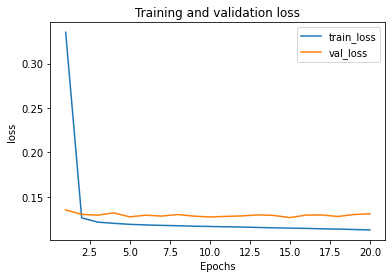

[25, 0.08024573833129627, 0.093507278934123, 0.11262052053418106]
 
 
TIME STEPS : -------->  26
Epoch 00007: early stopping


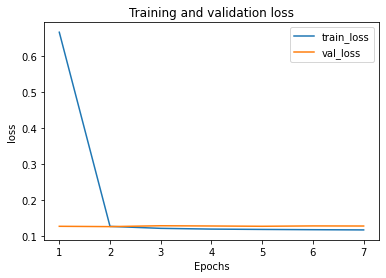

[26, -0.03628847812746259, 0.029286393202720685, 0.0656906459300672]
 
 
TIME STEPS : -------->  27
Epoch 00009: early stopping


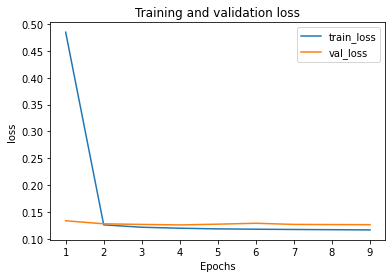

[27, 0.04068444635961199, 0.06761526332474266, 0.07682083585599539]
 
 
TIME STEPS : -------->  28
Epoch 00019: early stopping


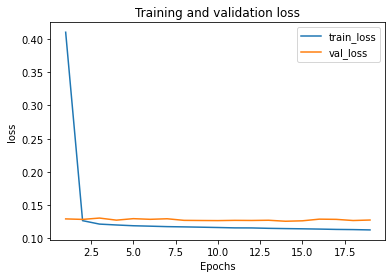

[28, 0.09573141218817703, 0.0908034434544681, 0.10589981267165689]
 
 
TIME STEPS : -------->  29
Epoch 00008: early stopping


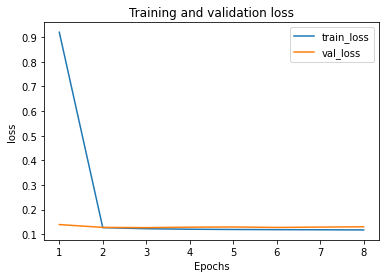

[29, -0.0010333477705064967, 0.04389464699802485, 0.08319796780405311]
 
 
TIME STEPS : -------->  30
Epoch 00017: early stopping


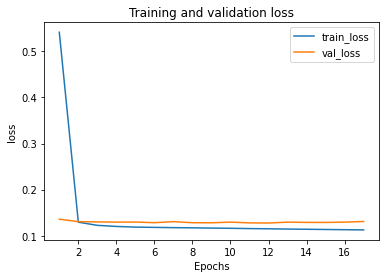

[30, 0.07187222532979981, 0.09427738458553273, 0.09889886954794375]
 
 
TIME STEPS : -------->  31
Epoch 00012: early stopping


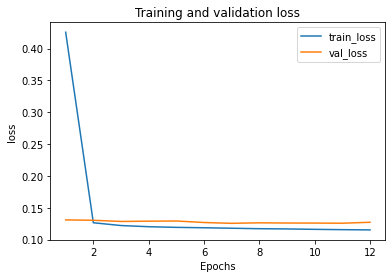

[31, 0.016123827095285558, 0.10382406468112308, 0.10575249748787895]
 
 
TIME STEPS : -------->  32
Epoch 00018: early stopping


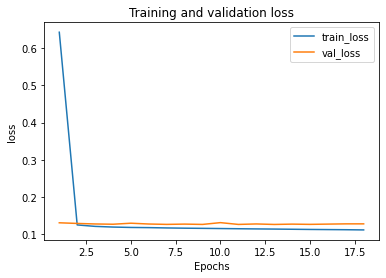

[32, 0.09088580828340595, 0.12152197697531086, 0.1098751548548912]
 
 
TIME STEPS : -------->  33
Epoch 00015: early stopping


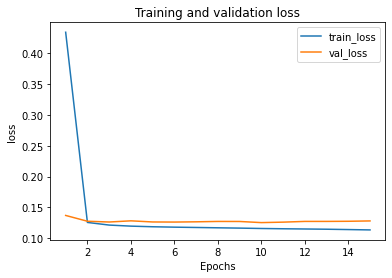

[33, 0.09525855909424669, 0.11756490097928878, 0.11431417750636172]
 
 
TIME STEPS : -------->  34
Epoch 00008: early stopping


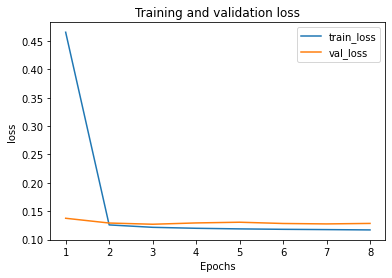

[34, 0.05196347970857242, 0.04164609574195086, 0.09513367228419718]
 
 
TIME STEPS : -------->  35
Epoch 00007: early stopping


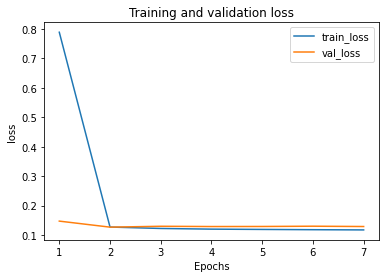

[35, -0.02549784245744199, -0.01483145425831563, 0.047340027128846704]
 
 


In [289]:
np.random.seed(60)
df = []
for i in range(25, 36):
    n_steps = i
    print( "TIME STEPS : --------> " , i)
    X_train, y_train = split_sequences(train_data_arr, n_steps)
    X_val, y_val = split_sequences(validation_data_arr, n_steps)

    n_input = X_train.shape[1] * X_train.shape[2]
    X_train = X_train.reshape((X_train.shape[0], n_input))
    X_val = X_val.reshape((X_val.shape[0], n_input))

    from keras.models import Sequential
    from keras.layers import Dense

    model = Sequential()
    model.add(Dense(1024, activation='sigmoid', input_dim=n_input))
    model.add(Dense(512, activation='relu'))
    # model.add(Dense(256, activation='relu'))
    model.add(Dense(150, activation='relu'))
    # model.add(Dense(50, activation='relu'))
    model.add(Dense(3))
    model.compile(optimizer='rmsprop', loss='mse')


    early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    mcp_save = ModelCheckpoint('./model.hdf5', save_best_only=True, monitor='val_loss', mode='min')

    batch_size = 64
    epochs = 250

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,verbose=None, validation_data=(X_val, y_val), 
                        callbacks=[early_stopping, mcp_save], shuffle=False)

    
    plot_metric(history, 'loss')
    plt.show()

    model.load_weights('model.hdf5')
    preds= model.predict(X_val, batch_size=batch_size)
    cols = ['target_r', 'target_g', 'target_b']
    preds = pd.DataFrame(preds, columns=cols)

    scores = []
    scores.append(n_steps)
    scores.append(scorer(y_val[:, 0], preds.target_r))
    scores.append(scorer(y_val[:, 1], preds.target_g))
    scores.append(scorer(y_val[:, 2], preds.target_b))
    df.append(pd.DataFrame(scores))
    print(scores)
    print(" ")
    print(" ")


In [141]:
# df

In [290]:
df = pd.concat(df, axis=1)
df.columns = df.iloc[0]
df.drop(df.index[0], inplace=True)

In [291]:
df.T

,1,2,3
0,,,
25.0,0.080246,0.093507,0.112621
26.0,-0.036288,0.029286,0.065691
27.0,0.040684,0.067615,0.076821
28.0,0.095731,0.090803,0.105900
29.0,-0.001033,0.043895,0.083198
30.0,0.071872,0.094277,0.098899
31.0,0.016124,0.103824,0.105752
32.0,0.090886,0.121522,0.109875
33.0,0.095259,0.117565,0.114314


In [292]:
df.T.mean(axis=1)

0
25.0    0.095458
26.0    0.019563
27.0    0.061707
28.0    0.097478
29.0    0.042020
30.0    0.088349
31.0    0.075233
32.0    0.107428
33.0    0.109046
34.0    0.062914
35.0    0.002337
dtype: float64

# NEW

In [293]:
train = pd.read_csv(train_datalink_X)
target = pd.read_csv(train_datalink_y)
test = pd.read_csv(hackathon_data_link)

In [294]:
train = pd.concat([train, target], axis=1)
# train = train.drop(['id', 'Moons'], axis=1)

In [295]:
train.shape

(14687, 17)

In [296]:
features = [f for f in train_data.columns if 'Feature' in f]
len(features)

14

In [297]:
validation_data = train[10000: ]
train_data = train[:10000]

In [299]:
validation_data.shape[0] - 33

4654

In [300]:
test_merge = validation_data[4655:]
test_merge.shape

(32, 17)

In [301]:
test.shape

(12910, 14)

In [303]:
cols = ['target_r', 'target_g', 'target_b']
test_merge.drop(columns=cols, inplace=True)

In [304]:
validation_data = validation_data[:4655]
validation_data.shape

(4655, 17)

In [305]:
train_data_arr = np.array(train_data)
validation_data_arr = np.array(validation_data)
validation_data_arr.shape

(4655, 17)

(9968, 33, 14)
(4623, 33, 14)
Epoch 00008: early stopping


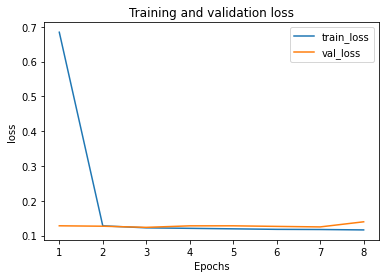

0.055463774821318264
0.10627915594568438
0.11833903780985469


In [307]:
np.random.seed(60)
n_steps = 33
X_train, y_train = split_sequences(train_data_arr, n_steps)
print(X_train.shape)
X_val, y_val = split_sequences(validation_data_arr, n_steps)
print(X_val.shape)
n_input = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape((X_train.shape[0], n_input))
X_val = X_val.reshape((X_val.shape[0], n_input))

from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(1024, activation='sigmoid', input_dim=n_input))
model.add(Dense(512, activation='relu'))
# model.add(Dense(256, activation='relu'))
model.add(Dense(150, activation='relu'))
# model.add(Dense(50, activation='relu'))
model.add(Dense(3))
model.compile(optimizer='rmsprop', loss='mse')


early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mcp_save = ModelCheckpoint('./model.hdf5', save_best_only=True, monitor='val_loss', mode='min')

batch_size = 64
epochs = 250



history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,verbose=0, validation_data=(X_val, y_val), 
                    callbacks=[early_stopping, mcp_save], shuffle=True)


plot_metric(history, 'loss')

model.load_weights('model.hdf5')
preds= model.predict(X_val, batch_size=batch_size)
cols = ['target_r', 'target_g', 'target_b']
preds = pd.DataFrame(preds, columns=cols)

print(scorer(y_val[:, 0], preds.target_r))
print(scorer(y_val[:, 1], preds.target_g))
print(scorer(y_val[:, 2], preds.target_b))

In [308]:
X_val.shape

(4623, 462)

In [309]:
test_data_with_lag = pd.concat([test_merge, test])
test_data_with_lag.shape

(12942, 14)

In [310]:
test.shape[0]

12910

In [311]:
def split_sequences_for_prediction(sequences, n_steps):
    X= list()   
    for i in range(len(sequences)):
# find the end of this pattern
        end_ix = i + n_steps
# check if we are beyond the dataset
        if end_ix > len(sequences):
            break
# gather input and output parts of the pattern
        seq_x =sequences[i:end_ix]
        # print(seq_x)
        X.append(seq_x)
    return np.array(X)

In [312]:
preds_data = split_sequences_for_prediction(np.array(test_data_with_lag[features]), 33)

In [313]:
preds_data.shape

(12910, 33, 14)

In [314]:
n_input

462

In [315]:
preds_data = preds_data.reshape((preds_data.shape[0], n_input))
preds_data.shape

(12910, 462)

In [ ]:
model.predict()

In [316]:
prediction = pd.DataFrame(model.predict(preds_data, batch_size=batch_size))

In [317]:
prediction.columns = cols

In [318]:
prediction['target_g'].nunique()

12866

In [319]:
test.shape, prediction.shape

((12910, 14), (12910, 3))

# Predictions

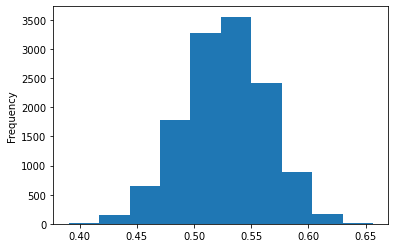

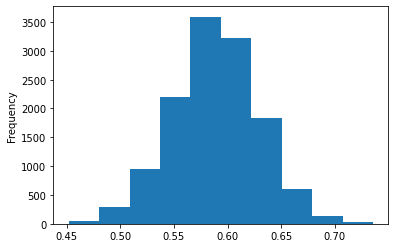

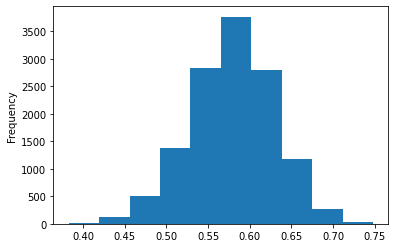

In [320]:
prediction['target_r'].plot(kind='hist')
plt.show()
prediction['target_g'].plot(kind='hist')
plt.show()
prediction['target_b'].plot(kind='hist')
plt.show()

In [321]:
API_KEY = "0GIskIC9Rd1I8sMw6nStutbIbMx7AaZzAyNfuMOVAVWgJtNa1IVQHZAD3WPj" # <- HERE

r = requests.post("https://tournament.datacrunch.com/api/submission",
    files = {
        "file": ("x", prediction.to_csv().encode('ascii'))
    },
    data = {
        "apiKey": API_KEY
    },
)

if r.status_code == 200:
    print("Submission submitted :)")
elif r.status_code == 423:
    print("ERR: Submissions are close")
    print("You can only submit during rounds eg: Friday 7pm GMT+1 to Sunday midnight GMT+1.")
    print("Or the server is currently crunching the submitted files, please wait some time before retrying.")
elif r.status_code == 422:
    print("ERR: API Key is missing or empty")
    print("Did you forget to fill the API_KEY variable?")
elif r.status_code == 404:
    print("ERR: Unknown API Key")
    print("You should check that the provided API key is valid and is the same as the one you've received by email.")
elif r.status_code == 400:
    print("ERR: The file must not be empty")
    print("You have send a empty file.")
elif r.status_code == 401:
    print("ERR: Your email hasn't been verified")
    print("Please verify your email or contact a cruncher.")
elif r.status_code == 429:
    print("ERR: Too many submissions")
else:
    print("ERR: Server returned: " + str(r.status_code))
    print("Ouch! It seems that we were not expecting this kind of result from the server, if the probleme persist, contact a cruncher.")

Submission submitted :)
